In [0]:
import matplotlib.pyplot as plt
import cv2
import numpy as np

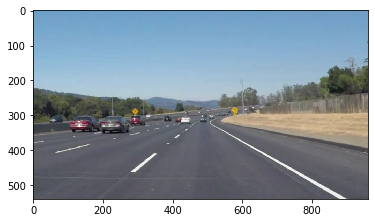

In [4]:
img = cv2.imread("data/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
plt.imshow(img)

In [0]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def canny(img, low_threshold, high_threshold):
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
  return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [0]:
def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len,
                            maxLineGap=max_line_gap)
    return lines

In [0]:
def get_slope(x1,y1,x2,y2):
    return (y2 - y1) / (x2 - x1 + np.finfo(float).eps)

In [0]:
def get_bias(slope, x1, y1):
        return y1 - (slope * x1)

In [0]:
def region_of_interest(img):
    imshape = img.shape

    lower_left = [imshape[1]/9, imshape[0]]
    lower_right = [imshape[1] - imshape[1]/9, imshape[0]]
    top_left = [imshape[1]/2 - imshape[1]/8, imshape[0]/2 + imshape[0]/10]
    top_right = [imshape[1] + imshape[1], imshape[0]/2 + imshape[0]/10]
    vertices = [np.array([lower_left, top_left, top_right, lower_right], dtype=np.int32)]
    #defining a blank mask to start with
    mask = np.zeros_like(img)

    # #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count # (255, 255, 255)
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [0]:
def compute_candidates(canditates_lines, img_shape):
    global left_lane, right_line
    # separate candidate lines according to their slope
    pos_lines = [l for l in canditates_lines if l["slope"] > 0]
    neg_lines = [l for l in canditates_lines if l["slope"] < 0]

    # interpolate biases and slopes to compute equation of line that approximates left lane
    # median is employed to filter outliers
    neg_bias = np.median([l["bias"] for l in neg_lines]).astype(int)
    neg_slope = np.median([l["slope"] for l in neg_lines])
    x1, y1 = 0, neg_bias
    x2, y2 = -np.int32(np.round(neg_bias / neg_slope)), 0
    left_lane = np.array([x1, y1, x2, y2])

    # interpolate biases and slopes to compute equation of line that approximates right lane
    # median is employed to filter outliers
    pos_bias = np.median([l["bias"] for l in pos_lines]).astype(int)
    pos_slope = np.median([l["slope"] for l in pos_lines])
    x1, y1 = 0, pos_bias
    x2, y2 = np.int32(np.round((img_shape[0] - pos_bias) / pos_slope)), img_shape[0]
    right_lane = np.array([x1, y1, x2, y2])

    return [left_lane, right_lane]

In [0]:
def get_lines(img, solid_line, rho, theta, threshold, min_line_len, max_line_gap):
    #Returns an image with hough lines drawn.
    #threshold is minimum number of intersections in a grid for candidate line to go to output
    
    # convert to grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # perform gaussian blur
    blur = gaussian_blur(img_gray, kernel_size=17)
    
    # perform edge detection
    canny_edges = canny(blur, low_threshold=50, high_threshold=120)
    
    detected_lines = hough_lines(img=canny_edges,
                                 rho=rho,
                                 theta=theta,
                                 threshold=threshold,
                                 min_line_len=min_line_len,
                                 max_line_gap=max_line_gap)
    
    if solid_line:
        candidate_lines = []
        for line in detected_lines:
            for x1, y1, x2, y2 in line:
                slope = get_slope(x1, y1, x2, y2)
                if 0.5 <= np.abs(slope) <= 2:
                    candidate_lines.append({"slope": slope, 
                                            "bias": get_bias(slope, x1, y1)})

        lane_lines = compute_candidates(candidate_lines, img_gray.shape)
    else:
        lane_lines = detected_lines

    return lane_lines

In [0]:
def draw_lines(line_img, left_right_lines, color=[255, 0, 0], thickness=10):
  for line in left_right_lines:
    x1, y1, x2, y2 = line
    cv2.line(line_img, (x1, y1), (x2, y2), color, thickness)

In [0]:
def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    return cv2.addWeighted(initial_img, α, img, β, λ)

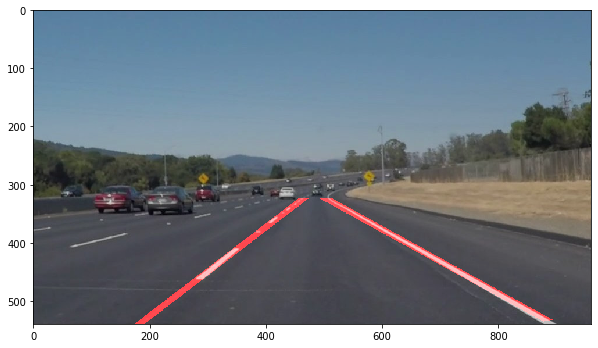

In [14]:

img = cv2.imread("data/test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

# detect lines
left_right_lines = get_lines(img=img, 
                             solid_line=True, 
                             rho=2, 
                             theta=np.pi/180, 
                             threshold=1, 
                             min_line_len=15, 
                             max_line_gap=5)

# prepare empty mask on which lines are drawn
line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)

# draw lines
draw_lines(line_img, left_right_lines)

# region of interest
masked_img = region_of_interest(line_img)
result = weighted_img(masked_img, img)

plt.figure(figsize=(10,10))
plt.imshow(result)